#### $ conda activate dinov2-semseg
Requires:
torch == 1.12.0a0+2c916ef.nv22.3,
cuda == 11.4,
torchvision == 0.13.0,
mmcv == 1.5.3,
xformers == 0.0.12,
mmseg == 0.27.0

In [9]:
import torch
import torchvision
import mmcv
import xformers
import mmseg
import matplotlib.pyplot as plt
import numpy as np

print(torch.__version__)
print(torch.version.cuda)
print(torchvision.__version__)
print(mmcv.__version__)
print(xformers.__version__)
print(mmseg.__version__)


1.12.0a0+2c916ef.nv22.3
11.4
0.13.0
1.5.3
0.0.12
0.27.0


In [25]:
! nvcc --version
! python --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Sun_Oct_23_22:16:07_PDT_2022
Cuda compilation tools, release 11.4, V11.4.315
Build cuda_11.4.r11.4/compiler.31964100_0
Python 3.8.20


## Utilities

In [1]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F

from dinov2.eval.depth.models import build_depther


class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_depther(cfg, backbone_model, backbone_size, head_type):
    train_cfg = cfg.get("train_cfg")
    test_cfg = cfg.get("test_cfg")
    depther = build_depther(cfg.model, train_cfg=train_cfg, test_cfg=test_cfg)

    depther.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
        return_class_token=cfg.model.backbone.output_cls_token,
        norm=cfg.model.backbone.final_norm,
    )

    if hasattr(backbone_model, "patch_size"):
        depther.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))

    return depther

/home/jetson/miniforge3/envs/dinov2-semseg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jetson/miniforge3/envs/dinov2-semseg/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


## Load pretrained backbone

In [2]:
%%capture
BACKBONE_SIZE = "giant" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()

## Load pretrained depth head

In [3]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_DATASET = "nyu" # in ("nyu", "kitti")
HEAD_TYPE = "dpt" # in ("linear", "linear4", "dpt")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")

model = create_depther(
    cfg,
    backbone_model=backbone_model,
    backbone_size=BACKBONE_SIZE,
    head_type=HEAD_TYPE,
)

load_checkpoint(model, head_checkpoint_url, map_location="cpu")
model.eval()
model.cuda()

load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_nyu_dpt_head.pth


DepthEncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): DPTHead(
    align_corners=False
    (loss_decode): ModuleList(
      (0): SigLoss()
      (1): GradientLoss()
    )
    (conv_depth): HeadDepth(
      (head): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Interpolate()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (relu): ReLU()
    (sigmoid): Sigmoid()
    (reassemble_blocks): ReassembleBlocks(
      (projects): ModuleList(
        (0): ConvModule(
          (conv): Conv2d(1536, 192, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): ConvModule(
          (conv): Conv2d(1536, 384, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvModule(
          (conv): Conv2d(1536, 768, kernel_size=(1, 1), stride=(1, 1))
        )
        (3): ConvModule(
        

## Load sample image

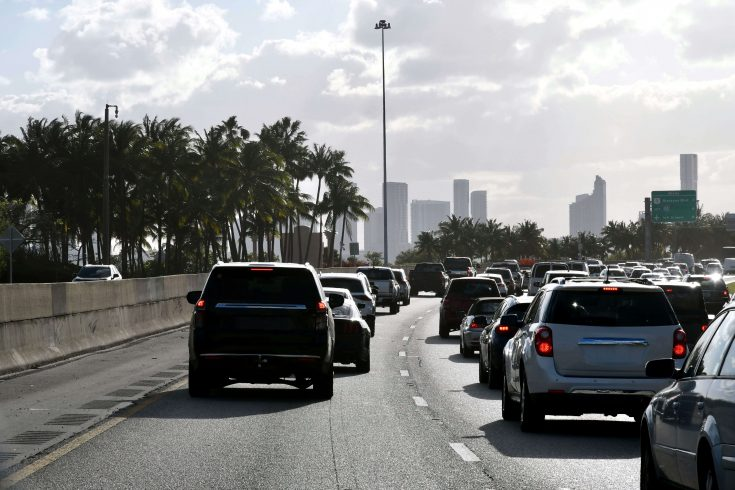

In [4]:
import urllib
import numpy as np
from IPython.display import Image
from PIL import Image


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


# Images from URL
# EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"
EXAMPLE_IMAGE_URL = "https://www.cobli.co/wp-content/uploads/2022/09/atencao-no-transito-735x490.jpg"
image = load_image_from_url(EXAMPLE_IMAGE_URL)

# Local images
# image = Image.open('/content/download.png')

display(image)

## Estimate depth on sample image

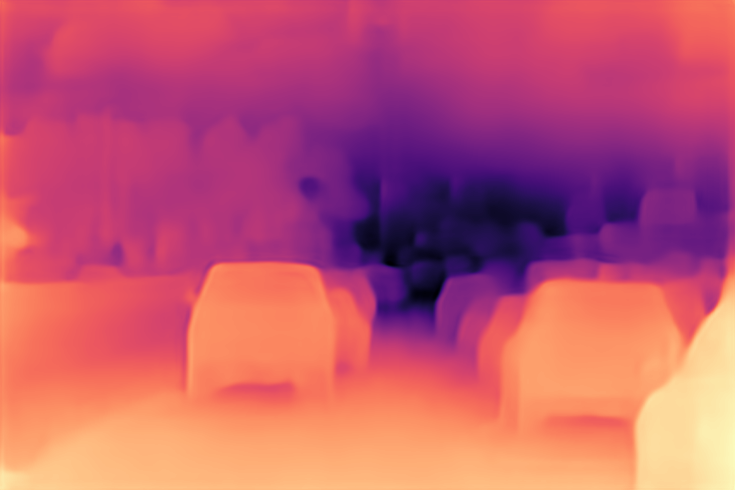

In [5]:
import matplotlib
from torchvision import transforms
torch.set_printoptions(profile="full")
import numpy as np
import pandas as pd


def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
        transforms.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
    ])


def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)


transform = make_depth_transform()

scale_factor = 1
rescaled_image = image.resize((scale_factor * image.width, scale_factor * image.height))
transformed_image = transform(rescaled_image)
batch = transformed_image.unsqueeze(0).cuda() # Make a batch of one image

with torch.inference_mode():
    result = model.whole_inference(batch, img_meta=None, rescale=True)

result_t = result.squeeze().cpu()
#print(result_t.shape)

# t_np = result_t.numpy() #convert to Numpy array
# df = pd.DataFrame(t_np) #convert to a dataframe
# df.to_csv("1_deep",index=False) #save to file

depth_image = render_depth(result.squeeze().cpu())
display(depth_image)